In [310]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  
plt.rcParams['figure.figsize'] = [12, 7]
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from itertools import combinations

#from read_clustering.src.read_clustering.variant_call import VariantCall
file_path = 'C:/Users/lalaj/PycharmProjects/untitled3/read_clustering/tests/test_files/native_cbf5_gal.csv'

class VariantCall(object):

    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.canonical = {"A", "C", "G", "T"}
        
    def get_subunit_data(self, subunit):  #assumes there is at least one read that covers all positions
        data = self.data.loc[self.data['contig'] == 'RDN' + str(subunit[0:2]) + '-1']
        data_2 = data.groupby(['reference_index']).nunique()
        positions = []
        variants = []
        for i, row in data_2.iterrows():
            x = positions.append(i)
        return x
        
    def get_reads_covering_positions_data(self, positions):   #don't need variants anymore 
        """return dataframe with probabilities for the modified variants in the given variant_set for the given position
        Params: positions: target positions as a list
            variants: target variants as a list in corresponding order to the positions list 
        Returns: df_plot: data frame with the probabilities for each variant at each position with corresponding read id.
            """
        data = self.data[self.data['reference_index'].isin (positions)]
        plot_data = data.loc[:,['read_id', 'reference_index', 'variants', 'prob1', 'prob2']]
        pos_n = len(positions)
        select = plot_data.groupby(['read_id']).nunique()
        select.columns = ['id_number', 'reference_index', 'variants', 'prob1', 'prob2']
        a = select[select['reference_index'] == pos_n]
        target_ids = list(a.index.values)        
        d = {}
        for pos in positions:
            d[str(pos)] =[]    
            
        for i in target_ids:
            r = (plot_data.loc[plot_data['read_id'] == i]).set_index('reference_index')    
            for index, row in r.iterrows():          
                d[str(index)].append(r.at[index, 'prob2'])
        
        df_plot = pd.DataFrame(list(zip(target_ids)))
        df_plot.columns = ['read_id']
        for key in d:
            col_val = ''
            col_val += 'P' + ' ' + str(key)
            df_plot[col_val] = d[key]     
        return df_plot

    def plot_tSNE_reads_covering_positions_data(self, positions, clusters_n, clustering_algorithm):
        temp_df = self.get_reads_covering_positions_data(positions)
        del temp_df['read_id']               

        tsne = TSNE(random_state=0)
        tsne_results = tsne.fit_transform(temp_df)
        tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
        
        if clustering_algorithm == 'GMM':
            gmm = GaussianMixture(n_components = clusters_n).fit(temp_df)     
            y_cluster = gmm.predict(temp_df)
        if clustering_algorithm == 'KM':
            kmeans = KMeans(n_clusters= clusters_n)       
            kmeans.fit(temp_df)
            y_cluster = kmeans.predict(temp_df)
        if clustering_algorithm == 'no':
            y_cluster = temp_df.values
            
        plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c = y_cluster, s = 30, cmap = 'rainbow')
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.title(str(len(positions)) + ' ' + 'positions' + ' ' + clustering_algorithm + ' ' + 'clustering')
        print('Number of reads in each cluster: ', Counter(kmeans.labels_))
        
        return plt.show()
    
    def plot_PCA_reads_covering_positions_data(self, positions, clusters_n, clustering_algorithm):
        temp_df = self.get_reads_covering_positions_data(positions)
        read_id = []
        read_id = temp_df['read_id']
        del temp_df['read_id']
        scaler = StandardScaler()
        scaler.fit(temp_df)
        scaled_data = scaler.transform(temp_df.values)
        pca = PCA(n_components=2)
        pca.fit(scaled_data)
        x_pca = pca.transform(scaled_data)
        if clustering_algorithm == 'GMM':
            gmm = GaussianMixture(n_components = clusters_n).fit(temp_df)    
            y_cluster = gmm.predict(temp_df)
        if clustering_algorithm == 'KM':
            kmeans = KMeans(n_clusters= clusters_n)       
            kmeans.fit(temp_df)
            y_cluster = kmeans.predict(temp_df)
        if clustering_algorithm == 'no':
                y_cluster = temp_df.values
        plt.scatter(x_pca[:, 0],x_pca[:, 1], s=40)
        plt.scatter(x_pca[:, 0],x_pca[:, 1], c = y_cluster, s = 40, cmap = 'rainbow')
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.title(str(len(positions)) + ' ' + 'positions' + ' ' + clustering_algorithm + ' ' + 'clustering')
        return plt.show()
    
    def plot_number_reads_covering_positions(self, positions):  
        d = {}
        data = self.data.loc[self.data['contig'] == 'RDN' + str(positions[0:2]) + '-1']
        data_2 = data.groupby(['reference_index']).nunique()  
        count_reads = data_2[['read_id']]
        number = count_reads['read_id'].sum()
        count_reads.plot(title = 'Reads for ' + positions + ' positions', legend = False)
        print ('Number of reads that cover ' + str(positions) + ': ' + str(number))
        plt.gca().invert_xaxis()
        return plt.show()      

In [311]:
native = VariantCall(file_path)

Number of reads that cover 18S: 91285


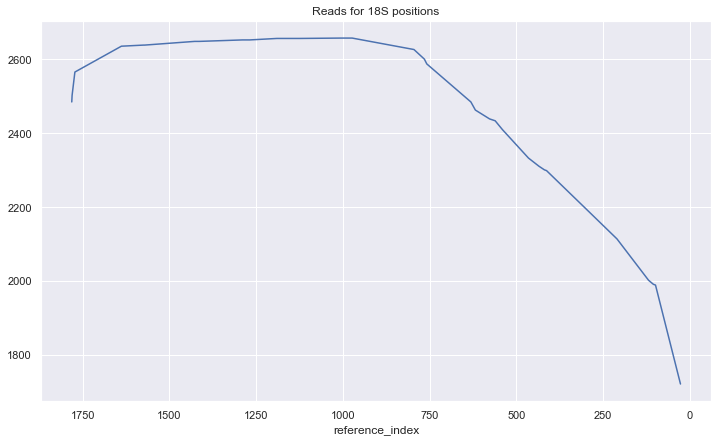

In [253]:
native.plot_number_reads_covering_positions('18S')

Number of reads that cover 25S: 80796


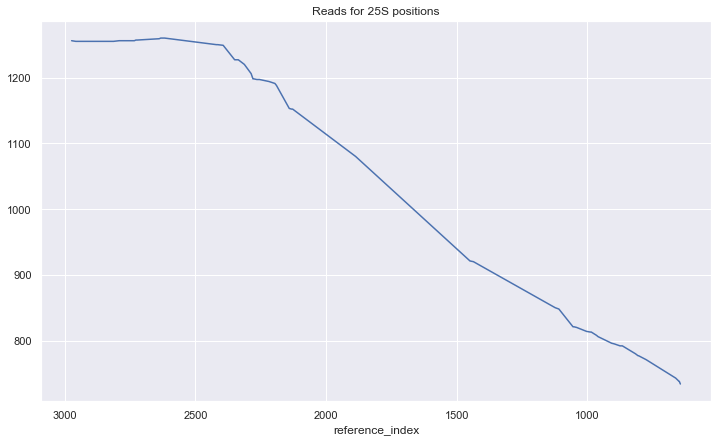

In [17]:
native.plot_number_reads_covering_positions('25S')

Now plotting and clustering the datasets. Coordinates are the probabilities. Each point is a read (one same read id) that covers all given positions. 

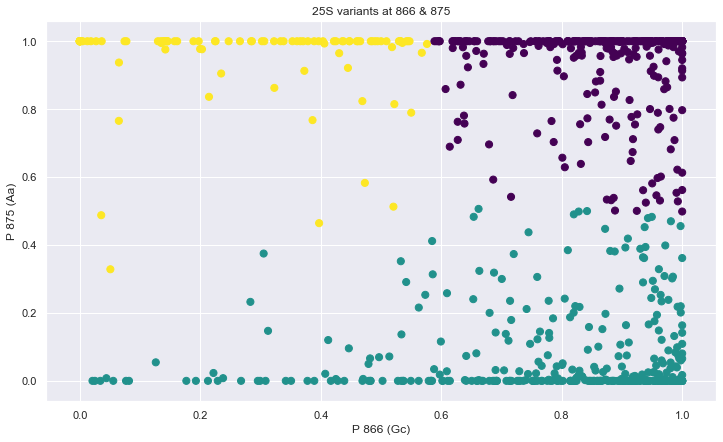

In [209]:
plot_df = native.get_reads_covering_positions_data([866, 875], ['Gc', 'Aa'])
X = plot_df.loc[:, ['P 866 (Gc)', 'P 875 (Aa)']].values 
kmeans = KMeans(n_clusters=3)             
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.title("25S variants at 866 & 875")
plt.xlabel('P 866 (Gc)')
plt.ylabel('P 875 (Aa)')
plt.show()

Now using GaussianMixture to cluster:

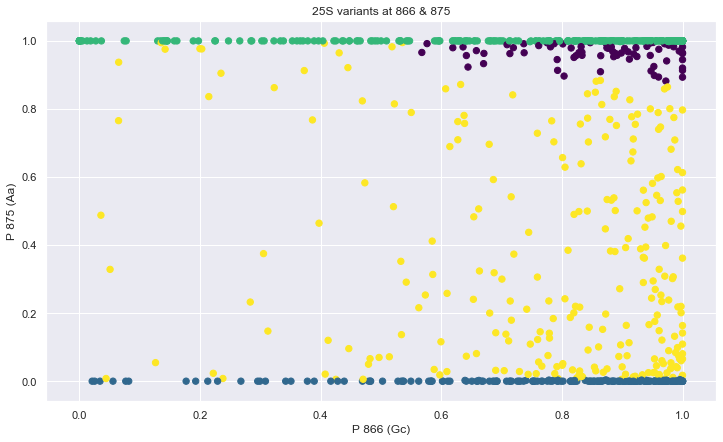

In [210]:
gmm = GaussianMixture(n_components=4).fit(X)     
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.title("25S variants at 866 & 875")
plt.xlabel('P 866 (Gc)')
plt.ylabel('P 875 (Aa)')
plt.show()

Now using t-SNE to do dimensionality reduction: to visualize a higher-dimension dataset in onle 2 dimensions. 

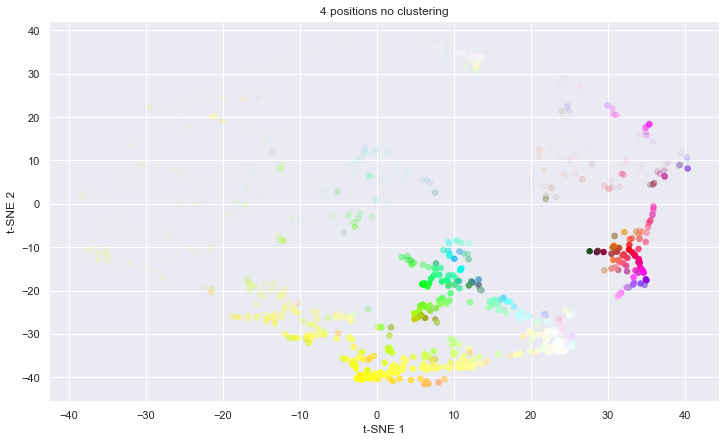

In [387]:
#4 random positions without any clustering
native.plot_tSNE_reads_covering_positions_data([2728, 2734, 2790, 2842],['Td','Tl', 'Gc', 'Th'], 10, 'no')    

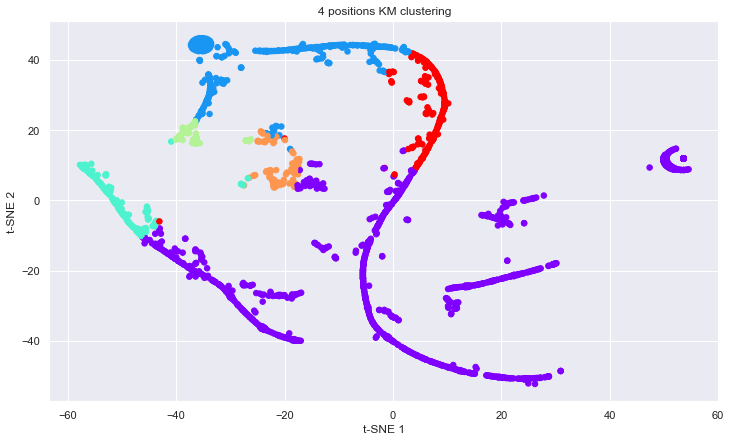

In [388]:
#Positions chosen toward the 3' end of 18S. 
#4 positions
native.plot_tSNE_reads_covering_positions_data([1638, 1574, 1571, 1427],
                                               ['Cb','Gk', 'Gc', 'Gc'], 6, 'KM') 

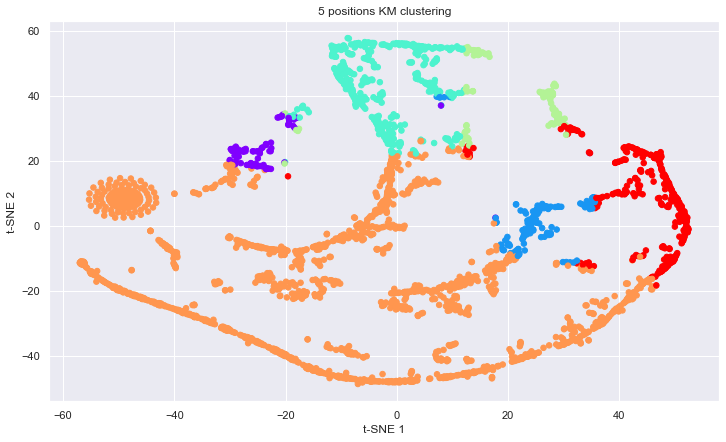

In [389]:
#5 positions
native.plot_tSNE_reads_covering_positions_data([1638, 1574, 1571, 1427, 1414],
                                               ['Cb','Gk', 'Gc', 'Gc', 'Tl'], 6, 'KM')

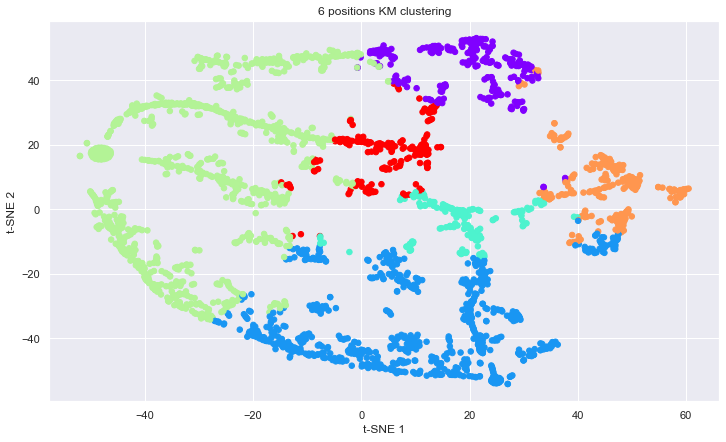

In [390]:
#6 positions
native.plot_tSNE_reads_covering_positions_data([1638, 1574, 1571, 1427, 1414, 1289],
                                               ['Cb','Gk', 'Gc', 'Gc', 'Tl', 'Tl'], 6, 'KM')

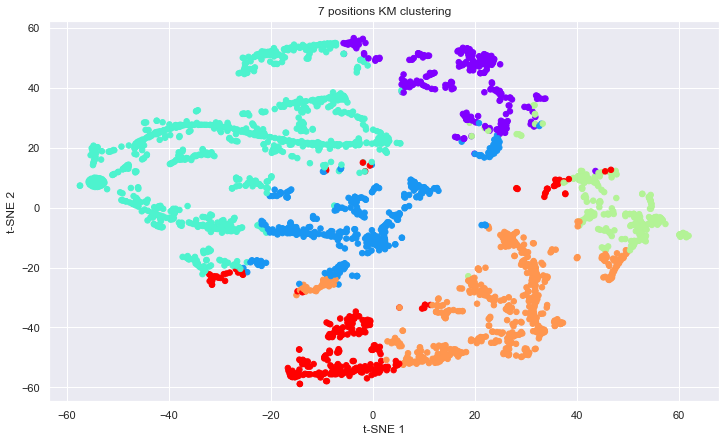

In [391]:
#7 positions
native.plot_tSNE_reads_covering_positions_data([1638, 1574, 1571, 1427, 1414, 1289, 1279],
                                               ['Cb','Gk', 'Gc', 'Gc', 'Tl', 'Tl', 'Ci'], 6, 'KM')

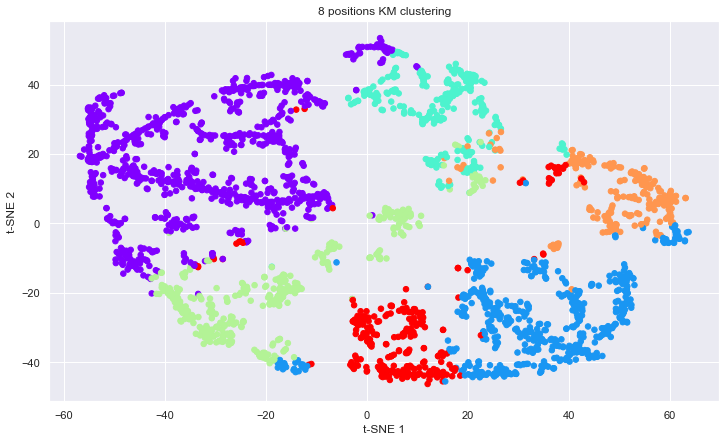

In [392]:
#8 positions
native.plot_tSNE_reads_covering_positions_data([1638, 1574, 1571, 1427, 1414, 1289, 1279, 1270],
                                               ['Cb','Gk', 'Gc', 'Gc', 'Tl', 'Tl', 'Ci', 'Gc'], 6, 'KM')

The method has also the option to cluster with GaussianMixture (but it shows to be more inaccurate).

In [ ]:
#8 positions with GMM
native.plot_tSNE_reads_covering_positions_data([1638, 1574, 1571, 1427, 1414, 1289, 1279, 1270],
                                               ['Cb','Gk', 'Gc', 'Gc', 'Tl', 'Tl', 'Ci', 'Gc'], 6, 'KM')

t-SNE plotting and KMeans clustering for all positions covered by all reads in 18S and 25S:

Number of reads in each cluster:  Counter({0: 512, 2: 473, 1: 257, 4: 238, 3: 129})


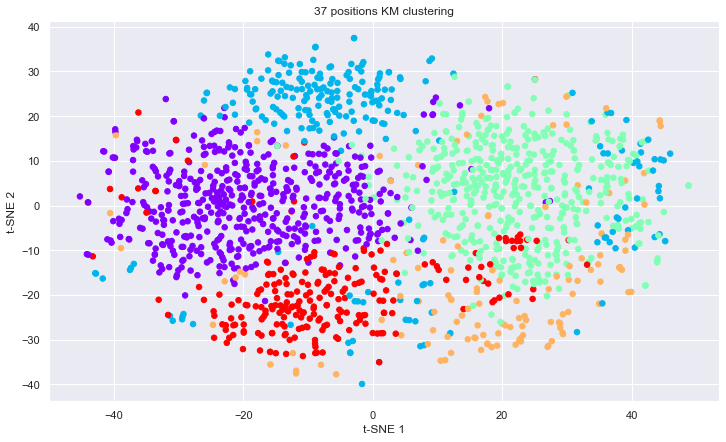

In [302]:
pos18S = native.get_subunit_data('18S')
native.plot_tSNE_reads_covering_positions_data([27, 99, 105, 119, 210, 301, 413, 419, 435, 465, 540, 561, 577, 618, 631, 758, 
                                                765, 795, 973, 998, 1006, 1125, 1180, 1186, 1190, 1268, 1270, 1279, 1289, 1414,
                                                1427, 1571, 1574, 1638, 1772, 1780, 1781], 5, 'KM')

Number of reads in each cluster:  Counter({0: 399, 1: 321})


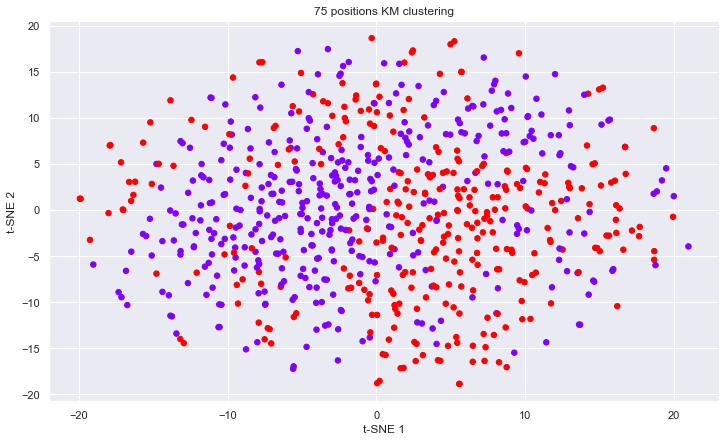

In [304]:
pos25S = native.get_subunit_data('25S')
native.plot_tSNE_reads_covering_positions_data([644, 648, 649, 662, 775, 804, 806, 816, 866, 875, 897, 907, 959, 965, 985, 989,
                                                1003, 1041, 1051, 1055, 1109, 1123, 1132, 1141, 1436, 1448, 1449, 1887, 2128, 
                                                2132, 2141, 2190, 2196, 2219, 2255, 2257, 2259, 2263, 2265, 2277, 2279, 2280, 
                                                2287, 2313, 2336, 2339, 2346, 2348, 2350, 2394, 2415, 2416, 2420, 2618, 2633, 
                                                2639, 2723, 2728, 2734, 2790, 2792, 2814, 2825, 2842, 2864, 2869, 2879, 2920, 
                                                2921, 2922, 2943, 2945, 2947, 2958, 2974], 2, 'KM')

PCA plotting and KMeans clustering for all positions covered by all reads in 18S and 25S:

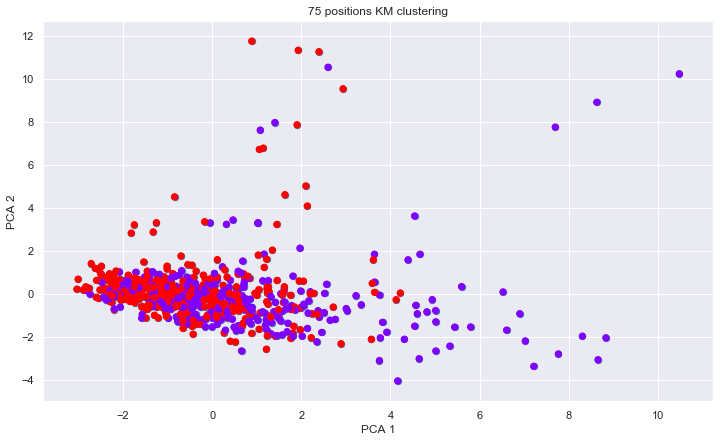

In [312]:
#25S
native.plot_PCA_reads_covering_positions_data([644, 648, 649, 662, 775, 804, 806, 816, 866, 875, 897, 907, 959, 965, 985, 989,
                                                1003, 1041, 1051, 1055, 1109, 1123, 1132, 1141, 1436, 1448, 1449, 1887, 2128, 
                                                2132, 2141, 2190, 2196, 2219, 2255, 2257, 2259, 2263, 2265, 2277, 2279, 2280, 
                                                2287, 2313, 2336, 2339, 2346, 2348, 2350, 2394, 2415, 2416, 2420, 2618, 2633, 
                                                2639, 2723, 2728, 2734, 2790, 2792, 2814, 2825, 2842, 2864, 2869, 2879, 2920, 
                                                2921, 2922, 2943, 2945, 2947, 2958, 2974], 2, 'KM')

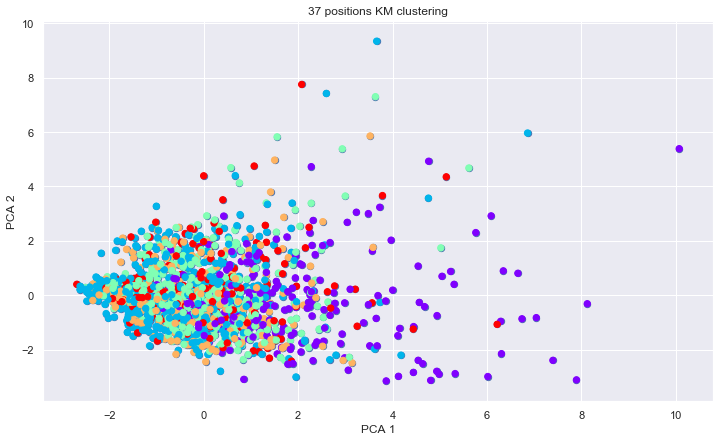

In [313]:
#18S
native.plot_PCA_reads_covering_positions_data([27, 99, 105, 119, 210, 301, 413, 419, 435, 465, 540, 561, 577, 618, 631, 758, 
                                                765, 795, 973, 998, 1006, 1125, 1180, 1186, 1190, 1268, 1270, 1279, 1289, 1414,
                                                1427, 1571, 1574, 1638, 1772, 1780, 1781], 5, 'KM')